In [30]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.ndimage as ndi
from sklearn.metrics import accuracy_score, f1_score

np.set_printoptions(suppress=True)

## Type consistency method.

- Each function will have a trailing underscore.
- Every actual function has to be called *only* through its helper which will have the same name without the underscore.
- The helper function is intended to check that the receiving and returning types are correct.

In [31]:
def readImage(path):
    assert isinstance(path, str), 'path is not str'
    r = _readImage(path)
    assert isinstance(r, np.ndarray), 'r is not np.ndarray'
    return r
def _readImage(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
    image = np.logical_not(image)
    plt.imshow(image, cmap="gray")
    #print(image.shape)
    return image

In [32]:
def transformImage(image, individual):
    assert isinstance(image, np.ndarray), "image is not np.ndarray"
    assert isinstance(individual, np.ndarray), "individual is not np.ndarray"
    r = _transformImage(image, individual)
    assert isinstance(r, np.ndarray), "r is not np.ndarray"
    return r
def _transformImage(image, individual):
    def scale(img, s):
        #s_x, s_y = 1/s_x, 1/s_y
        mat_scale = np.float32([[s, 0, 0],[0, s, 0]]) #scale image matrix in x and y.
        return cv2.warpAffine(np.float32(img), mat_scale, (img.shape[1], img.shape[0]))
        
    def move(img, t_x, t_y):
        mat_move = np.float32([[1,0,t_x],[0,1,t_y]]) 
        return cv2.warpAffine(np.float32(img), mat_move, (img.shape[1], img.shape[0]))

    def rotate(img, theta):
        rows, cols = img.shape
        mat_rotate = cv2.getRotationMatrix2D(((cols-1)/2.0, (rows-1)/2.0), theta, 1)
        return cv2.warpAffine(np.float32(img), mat_rotate, (cols,rows))

        #mat_rotate = np.float32([[1,0,w/2],[0,1,h/2],[0,0,1]]) @ np.float32([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]]) @ np.float32([[1,0,-w/2],[0,1,-h/2],[0,0,1]])
        #return cv2.warpAffine(np.float32(img), mat_rotate, (img.shape[1], img.shape[0]))
    result = image.copy()
    result = rotate(result, individual[2])
    result = scale(result, individual[3])
    result = move(result, individual[0], individual[1])
    return result.astype(bool)

In [ ]:
def fitness(original, child):
    assert isinstance(original, np.ndarray), "original is not np.ndarray"
    assert isinstance(child, np.ndarray), "child is not np.ndarray"
    r = _fitness(original, child)
    assert isinstance(r, float), "r is not float"
    return r
def _fitness(original, child):
    #return accuracy_score(original, child, normalize = True)
    #h, w = original.shape
    #return h*w - np.sum(original^child)
    #return np.sum(np.logical_and(original, child))
    return f1_score(original, child, average = 'micro')   


In [34]:
def initial_population(n, nvar, mbounds):
    assert isinstance(n, int), "n is not int"
    assert isinstance(nvar, int), "nvar is not int"
    assert isinstance(mbounds, np.ndarray), "mbounds is not np.ndarray"
    r = _initial_population(n, nvar, mbounds)
    assert isinstance(r, np.ndarray), "r is not np.ndarray"
    return r
def _initial_population(n, nvar, mbounds):
    population = np.zeros((n,nvar*2))
    for i in range(n):
        for j in range(nvar*2):
            if(mbounds[j][2] == "u"):
                population[i,j] = np.round(np.random.uniform(float(mbounds[j][0]), float(mbounds[j][1])), 2)
            else:
                population[i,j] = 1
    return population   

In [35]:
def pickParents(population):
    assert isinstance(population, np.ndarray), "population is not np.ndarray"
    r = _pickParents(population)
    assert isinstance(r, np.ndarray), "r is not np.ndarray"
    return r
def _pickParents(population):
    p1 = np.random.randint(0,population.shape[0])
    p2 = np.random.randint(0, population.shape[0])
    return np.array([population[p1], population[p2]])
def crossover(parents):
    assert isinstance(parents, np.ndarray), "parents is not np.ndarray"
    r = _crossover(parents)
    assert isinstance(r, np.ndarray), "r is not np.ndarray"
    return r
def _crossover(parents):
    selected = np.random.randint(0,2)
    return parents[selected]

In [36]:
def survivorSelection(n, fitnesses):
    assert isinstance(n, int), "n is not int"
    assert isinstance(fitnesses, np.ndarray), "fitnesses is not np.ndarray"
    r = _survivorSelection(n, fitnesses)
    assert isinstance(r, np.ndarray), "r is not np.ndarray"
    return r
def _survivorSelection(n, fitnesses):
    fitnesses = np.argsort(fitnesses)[:: -1]
    return fitnesses[: n]

In [37]:
def mutation(individual):
    assert isinstance(individual, np.ndarray), "individual is not np.ndarray"
    r = _mutation(individual)
    assert isinstance(r, np.ndarray), "r is not np.ndarray"
    return r
def _mutation(individual):
    half = individual.shape[0] // 2
    individual = [v + np.random.normal(0, i + half) for i, v in enumerate(individual)]
    return np.array(individual)

In [38]:
def evolutionStrategies(n, o, g): #Population size, Offspring size, Maximum number of generations
    assert isinstance(n, int), "n is not int" 
    assert isinstance(o, int), "o is not int" 
    assert isinstance(g, int), "g is not int" 
    r = _evolutionStrategies(n, o, g)
    assert isinstance(r, np.ndarray), "r is not np.ndarray"
    return r
def _evolutionStrategies(n, o, g):
    target = readImage("../../data/panamericana2.PNG")
    img = readImage("../../data/panamericana1.PNG")
    h, w = img.shape
    """
    mbounds = np.array([(-w/2, w/2, "u"), #x
                    (-h/2, h/2, "u"), #y
                    (-180, 180, "u"), #theta
                    (0.5, 1.5, "u"), #alpha
                    (0, w/10, "n"),
                    (0, h/10, "n"),
                    (0, 30, "n"),
                    (0, 0.1, "n")])
    """
    mbounds = np.array([(-w/4, w/4, "u"), #x
                    (-h/4, h/4, "u"), #y
                    (-180, 180, "u"), #theta
                    (0.5, 1.5, "u"), #alpha
                    (0, w/10, "n"),
                    (0, h/10, "n"),
                    (0, 30, "n"),
                    (0, 0.1, "n")])
    population = initial_population(n, int(mbounds.shape[0]/2), mbounds)

    #print(population)

    f = [fitness(target, transformImage(img, i)) for i in population]
    elite = population[np.argmax(f)].copy()
    """
    print(fitness(img, img), f)
    print(elite, f[elite])
    plt.imshow(transformImage(img, population[elite]), cmap = "gray")
    print(population[elite])
    """
    for i in range(g):
        offspring = [crossover(pickParents(population)) for i in range(o)]
        
        population = [mutation(i) for i in population]
        offspring = [mutation(i) for i in offspring]

        nF = [fitness(target, transformImage(img, i)) for i in offspring]
        pIndices = survivorSelection(n, np.concatenate((f, nF)))
        population = [population[i] if i < n else offspring[i % n] for i in pIndices]

        possibleElite = population[pIndices[0]] if pIndices[0] < n else offspring[pIndices[0] % n]
        if fitness(target, transformImage(img, possibleElite)) > fitness(target, transformImage(img, elite)):
            elite = possibleElite.copy()
        else: population[n - 1] = elite.copy()
        population = np.array(population)
    return elite

## Image to be transformed

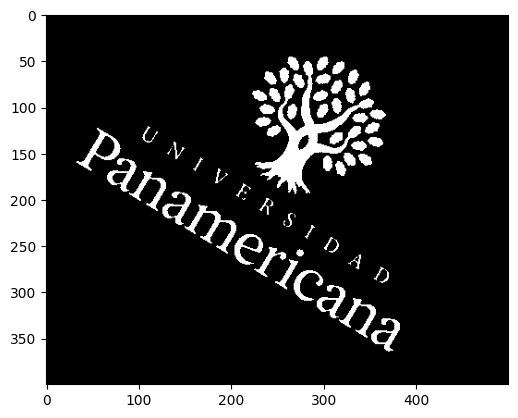

In [39]:
image = readImage("../../data/panamericana1.PNG")

## Target image

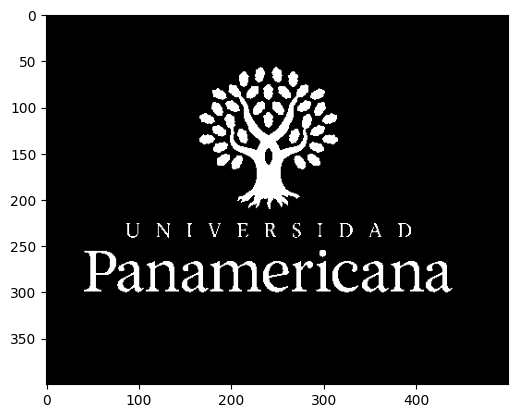

In [40]:
target = readImage("../../data/panamericana2.PNG")

(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500) (400, 500)
(400, 500)

KeyboardInterrupt: 

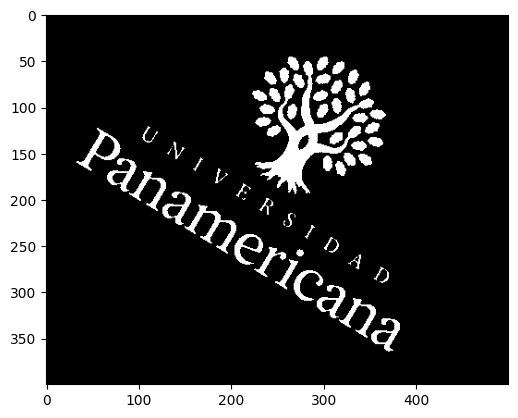

In [42]:
#r = evolutionStrategies(100, 50, 1000) 0.4685099404436517 [9.68627676   24.43471777   28.61000854    0.93402867+6+]**6]
r = evolutionStrategies(500, 250, 100)
i = transformImage(image, r)
print(fitness(target, i), r)
plt.imshow(i, cmap = "gray")

## Best known solution

0.8286005055644923 [-1 22 31  1  0  0  0  0]


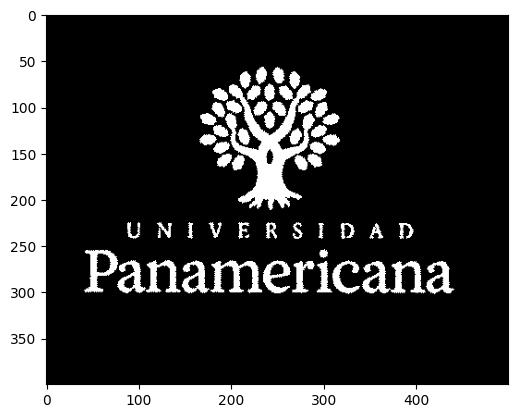

In [ ]:
r = np.array([-1, 22, 31, 1, 0, 0, 0, 0]) #Approximated solution
i = transformImage(image, r)
print(fitness(target, i), r)
plt.imshow(i, cmap = "gray")